# 神经网络实现鸢尾花分类

### <font color='red'><strong>Step1、数据集读入</strong> </font> 

从sklearn包datasets读入数据集

In [74]:
# 导入所需模块
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np

In [75]:
x = datasets.load_iris()
# print(x)
# 返回iris数据集所有输入特征
x_data = datasets.load_iris().data
# print(x_data)
# 返回iris数据集所有标签
y_data = datasets.load_iris().target
# print(y_data)

### <font color='red'><strong>Step2、数据集乱序</strong> </font> 

In [76]:
# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
# shuffle(x)对集合x里的数据进行乱序,x可以是数组或list等
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

### <font color='red'><strong>Step3、数据集分出永不想见的训练集和测试集</strong> </font> 

In [77]:
# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
# 冒号 : 的解释：如果只放置一个参数，如 [2]，将返回与该索引相对应的单个元素。如果为 [2:]，表示从该索引开始以后的所有项都将被提取。
# 如果使用了两个参数，如 [2:7]，那么则提取两个索引(不包括停止索引)之间的项。
# -30表示后30行
# [:-30] 表示从开始到第后30行，也就是前120行
x_train = x_data[:-30]
y_train = y_data[:-30]

# [-30:] 表示倒数第30行到最后，也就是后30行
x_test = x_data[-30:]
y_test = y_data[-30:]

### <font color='red'><strong>Step4、配成[输入特征,标签]对，每次喂入一小撮(batch)</strong> </font> 

In [78]:
# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

In [80]:
# 配对
# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
# batch(32)中的32代表32组
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


tf.Tensor(
[[6.1 2.8 4.  1.3]
 [6.3 3.3 4.7 1.6]
 [6.8 2.8 4.8 1.4]
 [5.3 3.7 1.5 0.2]
 [5.4 3.4 1.7 0.2]
 [6.5 3.  5.8 2.2]
 [7.2 3.6 6.1 2.5]
 [6.3 3.3 6.  2.5]
 [6.7 3.  5.  1.7]
 [4.9 3.1 1.5 0.2]
 [5.4 3.9 1.7 0.4]
 [6.5 3.2 5.1 2. ]
 [5.7 4.4 1.5 0.4]
 [5.9 3.2 4.8 1.8]
 [5.1 3.3 1.7 0.5]
 [5.1 2.5 3.  1.1]
 [4.9 3.6 1.4 0.1]
 [6.2 2.9 4.3 1.3]
 [5.8 2.8 5.1 2.4]
 [6.8 3.2 5.9 2.3]
 [6.2 2.2 4.5 1.5]
 [4.9 3.1 1.5 0.1]
 [4.7 3.2 1.6 0.2]
 [4.6 3.4 1.4 0.3]
 [5.2 4.1 1.5 0.1]
 [6.3 2.5 4.9 1.5]
 [5.4 3.  4.5 1.5]
 [6.  2.2 4.  1. ]
 [4.6 3.2 1.4 0.2]
 [6.4 2.8 5.6 2.1]
 [5.  3.4 1.5 0.2]
 [6.7 3.1 5.6 2.4]
 [5.7 2.6 3.5 1. ]
 [7.7 2.8 6.7 2. ]
 [6.9 3.1 5.4 2.1]
 [4.9 2.5 4.5 1.7]
 [5.4 3.4 1.5 0.4]
 [6.3 2.9 5.6 1.8]
 [7.7 3.8 6.7 2.2]
 [6.9 3.1 4.9 1.5]
 [5.1 3.5 1.4 0.2]
 [6.3 2.8 5.1 1.5]
 [6.4 3.2 5.3 2.3]
 [6.1 3.  4.9 1.8]
 [6.5 3.  5.5 1.8]
 [5.7 3.8 1.7 0.3]
 [5.5 4.2 1.4 0.2]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.  3.  1.6 0.2]
 [5.5 3.5 1.3 0.2]
 [4.4 3.2 1.3 0.2]
 

### <font color='red'><strong>Step5、定义神经网络中所有可训练参数</strong> </font> 

In [81]:
# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
# tf.random.truncated_normal()截断正态分布????这个鬼需要好好了解一下：1.为什么要用它，直接用原始数据不行么？？？
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))
print(w1)
print(b1)

<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[ 0.08249953, -0.0683137 ,  0.19668601],
       [-0.05480815,  0.04570521,  0.1357149 ],
       [ 0.07750896, -0.16734955, -0.10294553],
       [ 0.15784004, -0.13311003,  0.06045313]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([-0.09194934, -0.12376948, -0.05381497], dtype=float32)>


### <font color='red'><strong>Step6、嵌套循环跌代，with结构参数，显示当前loss</strong> </font> 

In [69]:
lr = 0.1  # 学习率为0.1
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 10  # 循环500轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和

In [71]:
# 训练部分
# enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中
for epoch in range(epoch):  #数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  #batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])

        # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
        w1.assign_sub(lr * grads[0])  # 参数w1自更新
        b1.assign_sub(lr * grads[1])  # 参数b自更新

    # 每个epoch，打印loss信息
    print("Epoch {}, loss: {}".format(epoch, loss_all/4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc)
    print("--------------------------")


Epoch 0, loss: 0.08543741516768932
Test_acc: 0.6
--------------------------
Epoch 1, loss: 0.08493702113628387
Test_acc: 0.6
--------------------------
Epoch 2, loss: 0.08444313704967499
Test_acc: 0.6333333333333333
--------------------------
Epoch 3, loss: 0.08395560085773468
Test_acc: 0.6333333333333333
--------------------------
Epoch 4, loss: 0.08347426354885101
Test_acc: 0.6333333333333333
--------------------------
Epoch 5, loss: 0.08299897983670235
Test_acc: 0.6333333333333333
--------------------------
Epoch 6, loss: 0.08252961002290249
Test_acc: 0.6333333333333333
--------------------------
Epoch 7, loss: 0.08206603676080704
Test_acc: 0.6333333333333333
--------------------------
Epoch 8, loss: 0.0816081278026104
Test_acc: 0.6333333333333333
--------------------------


### <font color='red'><strong>Step7、计算当前参数前向传播后的准确率真，显示当前acc</strong> </font> 

### <font color='red'><strong>Step8、acc/loss可视化</strong> </font> 

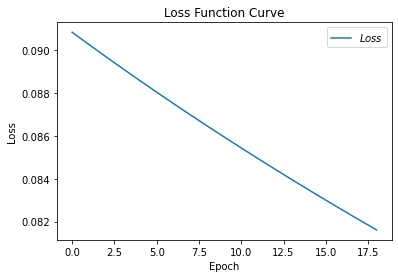

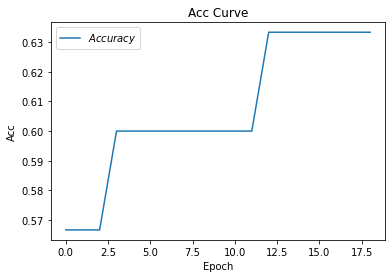

In [72]:
# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()